In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm, uniform
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange
from abc import ABC, abstractmethod
from shared.config_plt import config_plt, get_fig_ax, save_my_fig, colors
from shared.utils import print_se_parentheses, rank
theta_rng = np.random.default_rng(seed=1)
data_rng = np.random.default_rng(seed=2)
config_plt()

In [2]:
theta_abs_lim = 5.
theta_min = -theta_abs_lim
theta_max = theta_abs_lim
theta_inc = 0.1
theta_vals = np.arange(theta_min, theta_max+0.00001, theta_inc)
n_theta_vals = theta_vals.size
alpha = 0.05
n_each = 7
n = 2*n_each
combs = list(combinations(range(n), n_each))
n_combs = len(combs)
n_combs_arange = np.arange(n_combs)
a_vals = np.full((n_combs, n), False, dtype=bool)
for i, c in enumerate(combs):
    a_vals[i, c] = True
    
class DiscretizedDist():
    def __init__(self, base_dist, vals, rng):
        self.base_dist = base_dist
        self.vals = vals.copy()
        self.rng = rng
        raw_probs = base_dist.pdf(vals)
        probs = raw_probs / raw_probs.sum()
        self.probs = probs
        self.cumprobs = np.cumsum(probs)
        self.pdf_lookup = pd.Series(probs, index=vals)
        
    def pdf(self, x):
        return self.pdf_lookup[x]
    
    def rv(self):
        u = self.rng.random()
        if u == self.cumprobs[-1]:  # Edge case
            idx = self.cumprobs.size - 1
        else:
            idx = np.argmax(u < self.cumprobs)
        return self.vals[idx]
    
    def rvs(self, size=1):
        if size > 1:
            x = np.array([self.rv() for _ in range(size)])
        else:
            x = self.rv()
        return x

    
class Analyzer(ABC):
    name: str
    
    def __init__(self, name, alpha, prior_dist):
        self.name = name
        self.alpha = alpha
        self.lower_quantile = alpha/2.
        self.upper_quantile = 1. - self.lower_quantile
        self.ci_quantiles = np.array([self.lower_quantile, self.upper_quantile])
        self.z_star = norm.ppf(1. - alpha/2.)
        self.prior_dist = prior_dist
    
    @abstractmethod
    def analyze(self, y, a, thetas) -> (float, float, float, float):
        """Return estimate, lower bound, upper bound, and nominal coverage rate"""
        pass

    
class ProbAnalyzer(Analyzer):   
    def __init__(self, name, alpha, prior_dist):
        super().__init__(name, alpha, prior_dist)
    
    def process_probs(self, raw_probs, thetas):
        raw_probs = np.asarray(raw_probs)
        raw_probs_sum = raw_probs.sum()
        posterior_mean = (raw_probs * thetas).sum() / raw_probs_sum
        probs = raw_probs / raw_probs_sum
        cum_probs = np.cumsum(probs)
        lower_idx = int(np.argmax(self.lower_quantile < cum_probs))
        if lower_idx > 0:
            lower_idx -= 1
        upper_idx = int(np.argmax(self.upper_quantile < cum_probs))
        lower_bound = thetas[lower_idx]
        upper_bound = thetas[upper_idx]
        nominal_coverage_rate = cum_probs[upper_idx] - cum_probs[lower_idx] + probs[lower_idx]
        return posterior_mean, lower_bound, upper_bound, nominal_coverage_rate


class PriorAnalyzer(ProbAnalyzer):
    def __init__(self, name: str, alpha: float, prior_dist):
        super().__init__(name, alpha, prior_dist)
    
    def analyze(self, y, a, thetas):
        raw_probs = self.prior_dist.pdf(thetas)
        return self.process_probs(raw_probs, thetas)

class BayesAnalyzer(ProbAnalyzer):
    @abstractmethod
    def get_likelihoods(self, y, a, thetas):
        pass
    
    def analyze(self, y, a, thetas):
        likelihoods = self.get_likelihoods(y, a, thetas)
        posterior_probs = self.get_posterior_probs(likelihoods, thetas)
        return self.summarize_posterior(posterior_probs, thetas)
    
    def get_posterior_probs(self, likelihoods, thetas):
        prior_probs = self.prior_dist.pdf(thetas)
        posterior_probs = prior_probs * likelihoods        
        return posterior_probs
    
    def summarize_posterior(self, posterior_probs, thetas):
        return self.process_probs(posterior_probs, thetas)
    

class BRIAnalyzer(BayesAnalyzer):
    def __init__(self, name: str, alpha: float, prior_dist, n_each: int, n_theta_vals: int, a_vals: np.ndarray):
        super().__init__(name, alpha, prior_dist)
        self.n_each = n_each
        self.n = 2*n_each
        self.n_theta_vals = n_theta_vals
        self.a_vals_3d = np.repeat(a_vals.copy()[np.newaxis, :, :], n_theta_vals, axis=0)
        self.not_a_vals_3d = ~self.a_vals_3d
        self.n_combs = a_vals.shape[0]
        
    def get_ys(self, y, a, thetas):
        thetas_repped = np.repeat(thetas.copy()[:, np.newaxis], self.n, axis=1)
        y0 = y - a*thetas_repped
        y1 = y0 + thetas_repped
        return y0, y1
    
    def get_ys_3d(self, y, a, thetas):
        y0, y1 = self.get_ys(y, a, thetas)
        y0_3d = np.repeat(y0[:, np.newaxis, :], self.n_combs, axis=1)
        y1_3d = np.repeat(y1[:, np.newaxis, :], self.n_combs, axis=1)
        return y0_3d, y1_3d

    
class RankSumAnalyzer(BRIAnalyzer):
    def get_likelihoods(self, y, a, thetas):
        ranks_observed = rank(y)
        rank_sum_observed = (ranks_observed * a).sum()
        
        y0_3d, y1_3d = self.get_ys_3d(y, a, thetas)
        y_3d = self.a_vals_3d*y1_3d + self.not_a_vals_3d*y0_3d
        ranks = rank(y_3d)  # Ranks last axis by default
        rank_sums = (ranks * self.a_vals_3d).sum(axis=2)
        
        likelihoods = (rank_sums == rank_sum_observed).mean(axis=1)
        return likelihoods

    
class BRIDiffMeansAnalyzer(BRIAnalyzer):
    def get_diff_means(self, y, a):
        treated_means_observed = (a*y).sum() / self.n_each
        control_means_observed = ((1.-a)*y).sum() / self.n_each
        diff_means_observed = treated_means_observed - control_means_observed
        return diff_means_observed
    
    def get_stats(self, y, a, thetas):
        diff_means_observed = self.get_diff_means(y, a)
        y0_3d, y1_3d = self.get_ys_3d(y, a, thetas)
        control_means = (self.not_a_vals_3d * y0_3d).sum(axis=2) / self.n_each
        treated_means = (self.a_vals_3d * y1_3d).sum(axis=2) / self.n_each
        diff_means = treated_means - control_means        
        return diff_means_observed, diff_means


class RoundedAnalyzer(BRIDiffMeansAnalyzer):
    def __init__(self, name: str, alpha: float, prior_dist, n_each: int, n_theta_vals: int, a_vals: np.ndarray, digits:int=1):
        super().__init__(name, alpha, prior_dist, n_each, n_theta_vals, a_vals)
        self.digits = digits
    
    def get_likelihoods(self, y, a, thetas):
        diff_means_observed, diff_means = self.get_stats(y, a, thetas)
        diff_means_observed_rounded = np.round(diff_means_observed, self.digits)
        diff_means_rounded = np.round(diff_means, self.digits)
        likelihoods = (diff_means_rounded == diff_means_observed_rounded).mean(axis=1)
        return likelihoods

    
class NeighborhoodAnalyzer(BRIDiffMeansAnalyzer):
    def __init__(self, name: str, alpha: float, prior_dist, n_each: int, n_theta_vals: int, a_vals: np.ndarray, eps: float):
        super().__init__(name, alpha, prior_dist, n_each, n_theta_vals, a_vals)
        self.eps = eps
    
    def get_likelihoods(self, y, a, thetas):
        diff_means_observed, diff_means = self.get_stats(y, a, thetas)
        below = diff_means < (diff_means_observed + self.eps)
        above = (diff_means_observed - self.eps) < diff_means
        in_neighborhood = below & above
        likelihoods = in_neighborhood.mean(axis=1)
        return likelihoods
    
    
class BRIAsympAnalyzer(BRIDiffMeansAnalyzer):
    def get_likelihoods(self, y, a, thetas):
        diff_means_obs = self.get_diff_means(y, a)
        y0, y1 = self.get_ys(y, a, thetas)
        avg_diff_means = (y1 - y0).mean(axis=1)
        s2_0 = y0.var(ddof=1)
        s2_1 = y1.var(ddof=1)
        s2_01 = (y1-y0).var(ddof=1)
        var_diff_means = (s2_0 + s2_1 - s2_01) / self.n_each
        likelihoods = norm.pdf(diff_means_obs, avg_diff_means, var_diff_means)
        return likelihoods


class FreqAnalyzer():
    def get_est_var(self, y, a, thetas):
        y1 = y[a]
        y0 = y[~a]
        est = y1.mean() - y0.mean()
        var = y1.var()/y1.size + y0.var()/y0.size
        return est, var
    
    
class DiffMeansAnalyzer(FreqAnalyzer, Analyzer):
    def analyze(self, y, a, thetas):
        est, var = self.get_est_var(y, a, thetas)
        se = np.sqrt(var)
        lb = est - self.z_star * se
        ub = est + self.z_star * se
        cr = 1. - self.alpha
        return est, lb, ub, cr

    
class LIBDiffMeansAnalyzer(FreqAnalyzer, BayesAnalyzer):
    def get_likelihoods(self, y, a, thetas):
        est, var = self.get_est_var(y, a, thetas)
        sd = np.sqrt(var)
        likelihoods = norm.pdf(thetas, est, sd)
        return likelihoods


prior_dist = DiscretizedDist(norm(loc=0., scale=1.), theta_vals, theta_rng)
methods = [
    PriorAnalyzer("Prior", alpha, prior_dist),
    DiffMeansAnalyzer("Diff-Means", alpha, prior_dist),
    LIBDiffMeansAnalyzer("LIB-Diff-Means", alpha, prior_dist),
    BRIAsympAnalyzer("BRI: Asymptotic", alpha, prior_dist, n_each, n_theta_vals, a_vals),
    RoundedAnalyzer("BRI: Rounded", alpha, prior_dist, n_each, n_theta_vals, a_vals, 1),
    NeighborhoodAnalyzer("BRI: Neighborhood", alpha, prior_dist, n_each, n_theta_vals, a_vals, 0.05),
    RankSumAnalyzer("BRI: Rank-sum", alpha, prior_dist, n_each, n_theta_vals, a_vals)
]
method_names = [m.name for m in methods]
n_methods = len(methods)

In [3]:
# Simulation setup
n_reps = 1000
posterior_means = np.zeros((n_reps, n_methods))
lower_bounds = np.zeros((n_reps, n_methods))
upper_bounds = np.zeros((n_reps, n_methods))
nominal_coverage_rates = np.zeros((n_reps, n_methods))
true_thetas = np.zeros(n_reps)

def sample_a():
    a_idx = data_rng.choice(n_combs_arange)
    return a_vals[a_idx]

# Simulation
for i in trange(n_reps):
    # Generate data
    a_init = sample_a()
    not_a_init = ~a_init
    y0_init = data_rng.normal(size=n) + data_rng.gamma(4., scale=0.25, size=n)
    y1_init = y0_init + 1. + data_rng.normal(size=n)
    ya_init = a_init*y1_init + not_a_init*y0_init
    true_theta_i = prior_dist.rvs()
    y0 = ya_init - a_init*true_theta_i
    y1 = y0 + true_theta_i
    true_thetas[i] = true_theta_i
    a = sample_a()
    not_a = ~a
    y = a*y1 + not_a*y0
    
    for j, method in enumerate(methods):
        # Get posterior probs
        pm, lb, ub, cr = method.analyze(y, a, theta_vals)
        posterior_means[i, j] = pm
        lower_bounds[i, j] = lb
        upper_bounds[i, j] = ub
        nominal_coverage_rates[i, j] = cr

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:55<00:00,  5.69it/s]


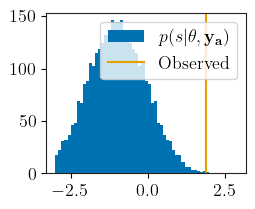

In [4]:
# Code for visualizing data
not_a_vals = ~a_vals
theta_val = -1.
y0_imputed = y - a*theta_val
y1_imputed = y0_imputed + theta_val
treated_means = (a_vals * y1_imputed).sum(axis=1) / n_each
control_means = (not_a_vals * y0_imputed).sum(axis=1) / n_each
diff_means = treated_means - control_means
diff_means_observed = ((a*y).sum() - ((1-a)*y).sum()) / n_each

figsize = (2.7, 2.2)
left_adjust = 0.22
bottom_adjust = 0.24
right_adjust = 0.96
top_adjust = 0.97
fig, ax = get_fig_ax(figsize=figsize)
ax.hist(diff_means, bins=np.arange(-3, 3, 0.1), color=colors[0], label="$p(s | \\theta, \\mathbf{y_a})$")
ax.axvline(diff_means_observed, color=colors[1], label="Observed")
plt.legend()
plt.subplots_adjust(left_adjust, bottom_adjust, right_adjust, top_adjust)
plt.show()

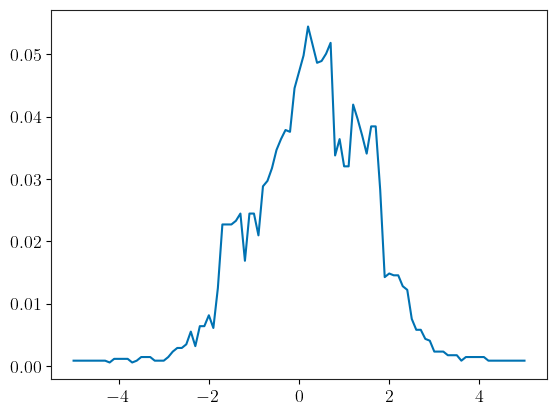

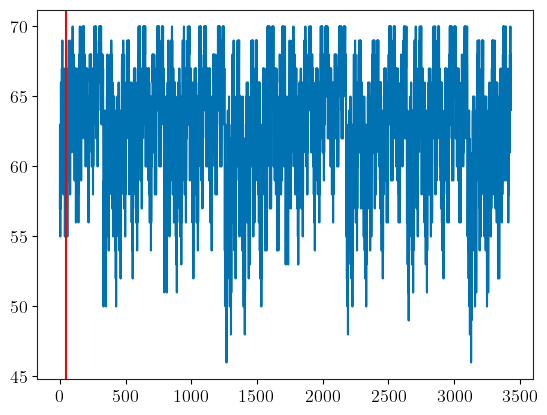

In [5]:
a_init = sample_a()
not_a_init = ~a_init
y0_init = data_rng.normal(size=n) + data_rng.gamma(4., scale=0.25, size=n)
y1_init = y0_init + 1. + data_rng.normal(size=n)
ya_init = a_init*y1_init + not_a_init*y0_init
true_theta_i = prior_dist.rvs()
y0 = ya_init - a_init*true_theta_i
y1 = y0 + true_theta_i
a = sample_a()
not_a = ~a
y = a*y1 + not_a*y0


rank_sum_method = RankSumAnalyzer("BRI: Rank-sum", alpha, prior_dist, n_each, n_theta_vals, a_vals)
likelihoods = rank_sum_method.get_likelihoods(y, a, theta_vals)
posterior_probs = rank_sum_method.get_posterior_probs(likelihoods, theta_vals)
plt.plot(theta_vals, likelihoods)
plt.show()

ranks_observed = rank(y)
rank_sum_observed = (ranks_observed * a).sum()

y0_3d, y1_3d = rank_sum_method.get_ys_3d(y, a, theta_vals)
y_3d = rank_sum_method.a_vals_3d*y1_3d + rank_sum_method.not_a_vals_3d*y0_3d
ranks = rank(y_3d, axis=2)
rank_sums = (ranks * rank_sum_method.a_vals_3d).sum(axis=2)

plt.plot(rank_sums[np.argmin(np.abs(theta_vals - (4)))])
plt.axvline(rank_sum_observed, color="red")
plt.show()

In [6]:
# Get mean and se
def get_mean_and_se(x, digits=3, stars=False, alpha=0.05):
    mean = x.mean(axis=0)
    se = x.std(axis=0) / np.sqrt(x.shape[0])
    mean_se = print_se_parentheses(mean, se, digits=digits, stars=stars, alpha=alpha)
    return mean_se

# Process results
errors = (posterior_means.T - true_thetas).T
errors2 = errors**2
ci_covered = ((lower_bounds.T <= true_thetas) & (true_thetas <= upper_bounds.T)).T
ci_length = upper_bounds - lower_bounds

arrs_to_process = [errors, errors2, ci_covered, nominal_coverage_rates, ci_length]
arrs_names_series = pd.Series(["Bias", "MSE", "CI Coverage", "CI Nominal Level", "CI Length"], name="Metrics")
method_names_series = pd.Series(method_names, name="Methods")

results_df = pd.DataFrame(
    np.stack([get_mean_and_se(arr, digits=3) for arr in arrs_to_process]).T,
    index=method_names_series,
    columns=arrs_names_series)
results_df

Metrics,Bias,MSE,CI Coverage,CI Nominal Level,CI Length
Methods,,,,,
Prior,-0.018 (0.031),0.990 (0.043),0.972 (0.005),0.964 (0.000),4.100 (0.000)
Diff-Means,0.004 (0.025),0.647 (0.029),0.898 (0.010),0.950 (0.000),2.821 (0.022)
LIB-Diff-Means,0.045 (0.021),0.433 (0.020),0.926 (0.008),0.967 (0.000),2.343 (0.012)
BRI: Asymptotic,0.066 (0.022),0.500 (0.025),0.869 (0.011),0.969 (0.000),2.100 (0.021)
BRI: Rounded,0.040 (0.022),0.471 (0.023),0.967 (0.006),0.964 (0.000),2.797 (0.013)
BRI: Neighborhood,0.040 (0.022),0.471 (0.023),0.967 (0.006),0.964 (0.000),2.795 (0.013)
BRI: Rank-sum,0.053 (0.022),0.476 (0.023),0.972 (0.005),0.963 (0.000),2.908 (0.013)


In [7]:
def get_pairwise_comparisons(x):
    results = np.full((n_methods, n_methods), "-", dtype="object")
    for i, method_name in enumerate(method_names):
        x_i = x[:, i]
        for j, method_name in enumerate(method_names):
            x_j = x[:, j]
            if i != j:
                results[i, j] = get_mean_and_se(x_i - x_j, stars=True, alpha=alpha)[0]
    return results

pairwise_df = pd.DataFrame(
    np.vstack([
        get_pairwise_comparisons(errors),
        get_pairwise_comparisons(errors2),
        get_pairwise_comparisons(ci_covered.astype(float)),
        get_pairwise_comparisons(nominal_coverage_rates),
        get_pairwise_comparisons(ci_length)]),
    index=pd.MultiIndex.from_product([arrs_names_series, method_names_series]),
    columns=method_names_series)
pairwise_df

Methods                                       Prior       Diff-Means  \
Metrics          Methods                                               
Bias             Prior                            -   -0.023 (0.040)   
                 Diff-Means           0.023 (0.040)                -   
                 LIB-Diff-Means      0.063 (0.025)*   0.041 (0.016)*   
                 BRI: Asymptotic     0.085 (0.023)*   0.062 (0.021)*   
                 BRI: Rounded        0.058 (0.020)*    0.035 (0.022)   
                 BRI: Neighborhood   0.058 (0.020)*    0.035 (0.022)   
                 BRI: Rank-sum       0.071 (0.022)*   0.049 (0.020)*   
MSE              Prior                            -   0.342 (0.048)*   
                 Diff-Means         -0.342 (0.048)*                -   
                 LIB-Diff-Means     -0.556 (0.039)*  -0.214 (0.023)*   
                 BRI: Asymptotic    -0.489 (0.033)*  -0.147 (0.025)*   
                 BRI: Rounded       -0.518 (0.031)*  -0.176 (0.027)*   
                 BRI: Neighborhood  -0.519 (0.031)*  -0.177 (0.027)*   
                 BRI: Rank-sum      -0.513 (0.034)*  -0.171 (0.026)*   
CI Coverage      Prior                            -   0.074 (0.011)*   
                 Diff-Means         -0.074 (0.011)*                -   
                 LIB-Diff-Means     -0.046 (0.009)*   0.028 (0.008)*   
                 BRI: Asymptotic    -0.103 (0.011)*  -0.029 (0.010)*   
                 BRI: Rounded        -0.005 (0.007)   0.069 (0.010)*   
                 BRI: Neighborhood   -0.005 (0.007)   0.069 (0.009)*   
                 BRI: Rank-sum        0.000 (0.006)   0.074 (0.009)*   
CI Nominal Level Prior                            -   0.014 (0.000)*   
                 Diff-Means         -0.014 (0.000)*                -   
                 LIB-Diff-Means      0.003 (0.000)*   0.017 (0.000)*   
                 BRI: Asymptotic     0.005 (0.000)*   0.019 (0.000)*   
                 BRI: Rounded       -0.001 (0.000)*   0.014 (0.000)*   
                 BRI: Neighborhood  -0.001 (0.000)*   0.014 (0.000)*   
                 BRI: Rank-sum      -0.001 (0.000)*   0.013 (0.000)*   
CI Length        Prior                            -   1.279 (0.022)*   
                 Diff-Means         -1.279 (0.022)*                -   
                 LIB-Diff-Means     -1.757 (0.012)*  -0.478 (0.011)*   
                 BRI: Asymptotic    -2.000 (0.021)*  -0.722 (0.009)*   
                 BRI: Rounded       -1.303 (0.013)*   -0.024 (0.014)   
                 BRI: Neighborhood  -1.305 (0.013)*   -0.027 (0.014)   
                 BRI: Rank-sum      -1.192 (0.013)*   0.086 (0.015)*   

Methods                              LIB-Diff-Means  BRI: Asymptotic  \
Metrics          Methods                                               
Bias             Prior              -0.063 (0.025)*  -0.085 (0.023)*   
                 Diff-Means         -0.041 (0.016)*  -0.062 (0.021)*   
                 LIB-Diff-Means                   -  -0.021 (0.007)*   
                 BRI: Asymptotic     0.021 (0.007)*                -   
                 BRI: Rounded        -0.006 (0.007)  -0.027 (0.004)*   
                 BRI: Neighborhood   -0.006 (0.007)  -0.027 (0.004)*   
                 BRI: Rank-sum        0.008 (0.006)  -0.013 (0.005)*   
MSE              Prior               0.556 (0.039)*   0.489 (0.033)*   
                 Diff-Means          0.214 (0.023)*   0.147 (0.025)*   
                 LIB-Diff-Means                   -  -0.067 (0.014)*   
                 BRI: Asymptotic     0.067 (0.014)*                -   
                 BRI: Rounded        0.038 (0.012)*  -0.029 (0.007)*   
                 BRI: Neighborhood   0.037 (0.012)*  -0.030 (0.007)*   
                 BRI: Rank-sum       0.043 (0.009)*  -0.024 (0.009)*   
CI Coverage      Prior               0.046 (0.009)*   0.103 (0.011)*   
                 Diff-Means         -0.028 (0.008)*   0.029 (0.010)*   
                 LIB-Diff-Means        